In [1]:
import sys
sys.path.append('/home/swang597/Documents/Research/Project_heightmap/Utility_projHM')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import numpy as np
import tqdm
import torchvision
from torchvision import datasets, models, transforms
import copy

# from sklearn.model_selection import train_test_split
# from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

import datetime
from MyDataset import MyDataset, MyDataset_multiple_dataset
import model_encoder_FNN as mymodel
from NNTrainer import NNTrainer
import argparse
import glob

import math
import gpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2

NUM_tasks = 3

In [17]:
import torch
import gpytorch

# Define the Gaussian Process Model
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [18]:
# Initialize training data
train_x = torch.rand(100, 43)  # Example training data (100 samples, 43 features)
train_y = torch.randn(100)  # Example target values

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)


In [19]:
# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

# Training loop
for i in range(50):  # 50 iterations of training
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    print(f'Iter {i+1}/{50} - Loss: {loss.item()}')


Iter 1/50 - Loss: 1.377173662185669
Iter 2/50 - Loss: 1.3516290187835693
Iter 3/50 - Loss: 1.3340803384780884
Iter 4/50 - Loss: 1.3229079246520996
Iter 5/50 - Loss: 1.3142009973526
Iter 6/50 - Loss: 1.3061541318893433
Iter 7/50 - Loss: 1.2996035814285278
Iter 8/50 - Loss: 1.2959054708480835
Iter 9/50 - Loss: 1.2956814765930176
Iter 10/50 - Loss: 1.2980201244354248
Iter 11/50 - Loss: 1.3009241819381714
Iter 12/50 - Loss: 1.3029693365097046
Iter 13/50 - Loss: 1.3036710023880005
Iter 14/50 - Loss: 1.3031634092330933
Iter 15/50 - Loss: 1.3018269538879395
Iter 16/50 - Loss: 1.3000152111053467
Iter 17/50 - Loss: 1.2979896068572998
Iter 18/50 - Loss: 1.2960307598114014
Iter 19/50 - Loss: 1.2945153713226318
Iter 20/50 - Loss: 1.2937873601913452
Iter 21/50 - Loss: 1.2939062118530273
Iter 22/50 - Loss: 1.2945371866226196
Iter 23/50 - Loss: 1.2951754331588745
Iter 24/50 - Loss: 1.2955217361450195
Iter 25/50 - Loss: 1.295620083808899
Iter 26/50 - Loss: 1.2956817150115967
Iter 27/50 - Loss: 1.29582

In [20]:
model.eval()
likelihood.eval()

# Test data
test_x = torch.rand(20, 43)  # Example test data (20 samples, 43 features)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))


ValueError: 'x' is not 1-dimensional

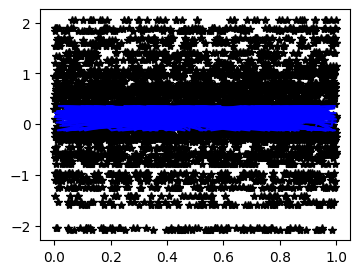

In [21]:
# plot the prediction
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [15]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=NUM_tasks
        )
        # self.covar_module = gpytorch.kernels.MultitaskKernel(
        #     gpytorch.kernels.RBFKernel(), num_tasks=NUM_tasks, rank=1
        # )
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=43)
)


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [3]:
# data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is {device}")
# read dataset ----------
phase = 1
fn_dataset_train = "/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/build_SCM_argVx/DEMO_OUTPUT/Dataset_train_96by72_2phase_varVx_I00V0_I01F0_240223/"
fn_dataset_test  = "/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/build_SCM_argVx/DEMO_OUTPUT/Dataset_test_96by72_2phase_varVx_I00V0_I01F0_240223/"

# HM_init_train_train = torch.load(fn_dataset_train +f'Iin_NNF_ts_train_p{phase}.pt')
# HM_init_train_test = torch.load(fn_dataset_train  +f'Iin_NNF_ts_test_p{phase}.pt')
HM_init_test_train = torch.load(fn_dataset_test   +f'Iin_NNF_ts_train_p{phase}.pt')
HM_init_test_test = torch.load(fn_dataset_test    +f'Iin_NNF_ts_test_p{phase}.pt')
# wheel_state_train_train = torch.load(fn_dataset_train +f'Vin_NNF_ts_train_p{phase}.pt') # z, vx, vz, wy
# wheel_state_train_test = torch.load(fn_dataset_train  +f'Vin_NNF_ts_test_p{phase}.pt')
wheel_state_test_train = torch.load(fn_dataset_test   +f'Vin_NNF_ts_train_p{phase}.pt')
wheel_state_test_test = torch.load(fn_dataset_test    +f'Vin_NNF_ts_test_p{phase}.pt')
# FN_train_train = torch.load(fn_dataset_train +f'Fout_NNF_ts_train_p{phase}.pt') # Fx, Fz, My
# FN_train_test = torch.load(fn_dataset_train  +f'Fout_NNF_ts_test_p{phase}.pt')
FN_test_train = torch.load(fn_dataset_test   +f'Fout_NNF_ts_train_p{phase}.pt')
FN_test_test = torch.load(fn_dataset_test    +f'Fout_NNF_ts_test_p{phase}.pt')

keyword = 'HMred_2phase_varVx_GP'


device is cuda


In [4]:
autoencoder = mymodel.SmallerFlexibleCNNAutoencoder((1,96,72), bottleneck_size=40).to(device)
# Step 3: Train the autoencoder
model_path_autoencoder = f'/home/swang597/Documents/Research/Project_heightmap/Model/Autoencoder/SmallerFlexibleCNNAutoencoder/best_model_bottleneck_40_seed21995_epoch4982_loss0.000005.pth'
# load the best model
autoencoder.load_state_dict(torch.load(model_path_autoencoder))

RF_HM_init_test_train = autoencoder.encode(HM_init_test_train.to(device))
RF_HM_init_test_test = autoencoder.encode(HM_init_test_test.to(device))

RF_HM_init_test_train = RF_HM_init_test_train.to(device)
RF_HM_init_test_test = RF_HM_init_test_test.to(device)
wheel_state_test_test = wheel_state_test_test.to(device)
wheel_state_test_train = wheel_state_test_train.to(device)

print("RF_HM_init_test_train.shape:",RF_HM_init_test_train.shape, "RF_HM_init_test_test.shape",RF_HM_init_test_test.shape)
print("wheel_state_test_train.shape",wheel_state_test_train.shape,"wheel_state_test_test.shape:",wheel_state_test_test.shape)

RF_HM_init_test_train.shape: torch.Size([25116, 40]) RF_HM_init_test_test.shape torch.Size([6279, 40])
wheel_state_test_train.shape torch.Size([25116, 3]) wheel_state_test_test.shape: torch.Size([6279, 3])


In [5]:
input_features_test_train = torch.cat((RF_HM_init_test_train, wheel_state_test_train), dim=1)
input_features_test_test = torch.cat((RF_HM_init_test_test, wheel_state_test_test), dim=1)

input_features_test_train = input_features_test_train[:100,:].to(device)
input_features_test_test = input_features_test_test[:100,:].to(device)
FN_test_train = FN_test_train[:100,:].to(device)
FN_test_test = FN_test_test[:100,:].to(device)
print("input_features_test_train.shape",input_features_test_train.shape, "input_features_tes_test.shape", input_features_test_test.shape)
print("FN_test_train.shape",FN_test_train.shape, "FN_test_test.shape",FN_test_test.shape)

input_features_test_train.shape torch.Size([100, 43]) input_features_tes_test.shape torch.Size([100, 43])
FN_test_train.shape torch.Size([100, 3]) FN_test_test.shape torch.Size([100, 3])


In [6]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)
model = MultitaskGPModel(input_features_test_train, FN_test_train, likelihood)
model = model.to(device)
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(input_features_test_train)
    print("output:",output, FN_test_train.shape)
    loss = -mll(output, FN_test_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task


output: MultitaskMultivariateNormal(mean shape: torch.Size([100, 3])) torch.Size([100, 3])
Iter 1/50 - Loss: 1.475
output: MultitaskMultivariateNormal(mean shape: torch.Size([100, 3])) torch.Size([100, 3])


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [16]:
import torch
import math
import gpytorch
from matplotlib import pyplot as plt

# train_x = torch.linspace(0, 1, 100)
# Number of data points
num_points = 100
# Number of features
num_features = 43

# Generate synthetic train_x with shape [100, 43]
train_x = torch.rand(num_points, num_features)

# train_y = torch.stack([
#     torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
#     torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
#     torch.sin(train_x * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2,  # Third task
# ], -1)

# train_x = input_features_test_train
train_y = FN_test_train.to('cpu')
print("train_x.shape",train_x.shape, "train_y.shape",train_y.shape)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)
model = MultitaskGPModel(train_x, train_y, likelihood)#.to(device)

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    print("output:",output, train_y.shape)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

# Set into eval mode
model.eval()
likelihood.eval()


# Initialize plots
f, axes = plt.subplots(1, 3, figsize=(12, 3))  # Adjusted for three subplots

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# Loop through each task
for i, ax in enumerate(axes):
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y[:, i].detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean[:, i].numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.numpy(), lower[:, i].numpy(), upper[:, i].numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(f'Task {i+1} Observed Values (Likelihood)')

plt.tight_layout()
plt.show()



train_x.shape torch.Size([100, 43]) train_y.shape torch.Size([100, 3])


RuntimeError: mean shape torch.Size([100, 3]) is incompatible with covariance shape torch.Size([100, 100])

train_x.shape torch.Size([100]) train_y.shape torch.Size([100, 2])
Iter 1/50 - Loss: 1.233
Iter 2/50 - Loss: 1.195
Iter 3/50 - Loss: 1.154
Iter 4/50 - Loss: 1.110
Iter 5/50 - Loss: 1.065
Iter 6/50 - Loss: 1.019
Iter 7/50 - Loss: 0.975
Iter 8/50 - Loss: 0.931
Iter 9/50 - Loss: 0.889
Iter 10/50 - Loss: 0.848
Iter 11/50 - Loss: 0.809
Iter 12/50 - Loss: 0.771
Iter 13/50 - Loss: 0.734
Iter 14/50 - Loss: 0.697
Iter 15/50 - Loss: 0.659
Iter 16/50 - Loss: 0.621
Iter 17/50 - Loss: 0.582
Iter 18/50 - Loss: 0.543
Iter 19/50 - Loss: 0.504
Iter 20/50 - Loss: 0.465
Iter 21/50 - Loss: 0.426
Iter 22/50 - Loss: 0.388
Iter 23/50 - Loss: 0.350
Iter 24/50 - Loss: 0.314
Iter 25/50 - Loss: 0.279
Iter 26/50 - Loss: 0.246
Iter 27/50 - Loss: 0.216
Iter 28/50 - Loss: 0.187
Iter 29/50 - Loss: 0.160
Iter 30/50 - Loss: 0.135
Iter 31/50 - Loss: 0.111
Iter 32/50 - Loss: 0.090
Iter 33/50 - Loss: 0.071
Iter 34/50 - Loss: 0.055
Iter 35/50 - Loss: 0.041
Iter 36/50 - Loss: 0.031
Iter 37/50 - Loss: 0.024
Iter 38/50 - Loss

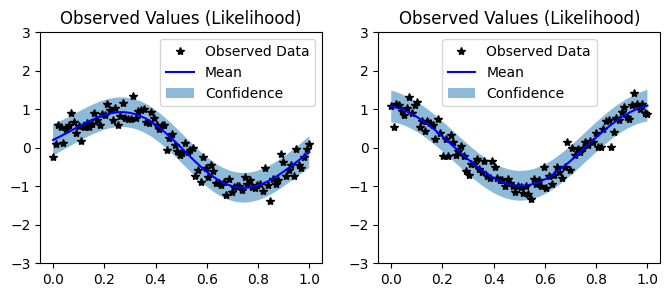

In [ ]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)
print("train_x.shape",train_x.shape, "train_y.shape",train_y.shape)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')
plt.show()

In [ ]:

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')
plt.show()